In [1]:
import tweepy
from textblob import TextBlob
from time import sleep
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from .conexion import getConnection
import nltk
import re
nltk.download
consumer_key = "F70Tuo2dL0e08mgLU7QTSP9R9"
consumer_secret = "I8jKWmBnq2qOlGVnRKintRztIL79q53YDmMUZV5phWpKW9SnBP"
access_key = "92553187-VF6nsdE1SLFglseQ2DMUBoGIb6ZxQ5FrdgmbM2ioD"
access_secret = "izY6ndERijvjOnHLz3e7TIjbAGJj2qlGj5aTf6ZSpoCuW"

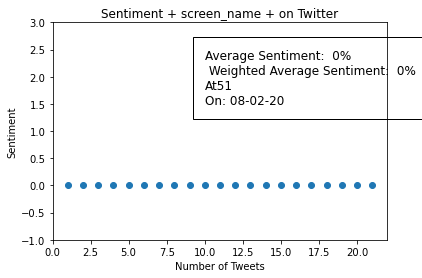

In [3]:
def get_all_tweets(screen_name,limit_number):
    limit_number = limit_number#3240
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    alltweets = []
    #Hacer una petición inicial por los 200 tweets más recientes (200 es el número máximo permitido)
    new_tweets = api.user_timeline(screen_name = screen_name,count=1)
    #guardar los tweets más recientes
    alltweets.extend(new_tweets)
    #guardar el ID del tweet más antiguo menos 1
    oldest = alltweets[-1].id - 1

    #recorrer todos los tweets en la cola hasta que no queden más
    while len(new_tweets) > 0 and len(alltweets) <= limit_number:
        #en todas las peticiones siguientes usar el parámetro max_id para evitar duplicados
        new_tweets = api.user_timeline(screen_name = screen_name,count=1,max_id=oldest)
        bd, connection = getConnection()

        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
        "]+", flags=re.UNICODE)
        
        texto = emoji_pattern.sub(r'', new_tweets[0]._json['text'])
        texto = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', texto)
        
        #print(texto)
        
        sql = "SELECT * FROM data_twitter WHERE id=%s"
        bd.execute(sql, (new_tweets[0]._json['user']['id_str']))
        account = bd.fetchone()

        if account:
            sql = "UPDATE data_twitter SET screen_name=%s,name=%s,location=%s,description=%s WHERE id = %s"
            bd.execute(sql, (new_tweets[0]._json['user']['screen_name'],new_tweets[0]._json['user']['name'],new_tweets[0]._json['user']['location'],new_tweets[0]._json['user']['description'],new_tweets[0]._json['user']['id_str']))
        else:
            sql = "INSERT INTO data_twitter VALUES (%s, %s, %s, %s, %s)"
            bd.execute(sql, (new_tweets[0]._json['user']['id_str'],new_tweets[0]._json['user']['screen_name'],new_tweets[0]._json['user']['name'],new_tweets[0]._json['user']['location'],new_tweets[0]._json['user']['description']))
        
        connection.commit()
            
        sql = "SELECT * FROM data_twitter_detalle WHERE id=%s"
        bd.execute(sql,(new_tweets[0]._json['id_str']))
        twit = bd.fetchone()

        if twit:
            sql = "UPDATE data_twitter_detalle SET text=%s WHERE id = %s"
            bd.execute(sql, (texto,new_tweets[0]._json['id_str']))
        else:
            sql = "INSERT INTO data_twitter_detalle VALUES (%s, %s, %s, %s, %s)"
            if(new_tweets[0]._json['place']):
                bd.execute(sql, (new_tweets[0]._json['id_str'],new_tweets[0]._json['user']['id_str'],texto,new_tweets[0]._json['place']['place_type'],new_tweets[0]._json['place']['name']))
            else:
                bd.execute(sql, (new_tweets[0]._json['id_str'],new_tweets[0]._json['user']['id_str'],texto,"",""))
        
        connection.commit()
            

        #guardar los tweets descargados
        alltweets.extend(new_tweets)
        #actualizar el ID del tweet más antiguo menos 1
        oldest = alltweets[-1].id - 1
        #informar en la consola como vamos
        #print(str(len(alltweets)-1) + " tweets descargados hasta el momento")

    #Realizar el análisis de sentimiento de los tweets descargados
        
    #Crear las listas de polaridad polarity_list y frecuencia de polaridad numbers_list
    polarity_list = []
    numbers_list = []
    number = 1
        
    for tweet in alltweets:
        try:
            analysis = TextBlob(tweet.text)
            #https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
            analysis = analysis.sentiment
            #print(analysis)
            #Guardar la polaridad
            polarity = analysis.polarity
            #print(analysis.polarity)
            polarity_list.append(polarity)
            #Contar las veces que esa polaridad ha ocurrido
            numbers_list.append(number)
            number = number + 1
        except tweepy.TweepError as e:
            print(e.reason)
        except StopIteration:
            break
            
    #Crear eje cartesiano
    plt.figure(limit_number)
    axes = plt.gca()
    axes.set_ylim([-1, 3])
    plt.scatter(numbers_list, polarity_list)
    
    #Calcular el promedio de polaridad, NOTA: No es promedio ponderado
    averagePolarity = (sum(polarity_list))/(len(polarity_list))
    averagePolarity = "{0:.0f}%".format(averagePolarity * 100)
    time  = datetime.now().strftime("At%M\nOn: %m-%d-%y")

    #Calcular el promedio ponderado
    weighted_avgPolarity = np.average(polarity_list, weights=numbers_list)
    weighted_avgPolarity = "{0:.0f}%".format(weighted_avgPolarity * 100)

    #Agregar texto con el promedio de sentimiento
    plt.text(10, 1.5, "Average Sentiment:  " + str(averagePolarity) + "\n" + " Weighted Average Sentiment:  " + str(weighted_avgPolarity) + "\n" + time, fontsize=12, bbox = dict(facecolor='none', edgecolor='black', boxstyle='square, pad = 1'))

    #Título
    plt.title("Sentiment + screen_name + on Twitter")
    plt.xlabel("Number of Tweets")
    plt.ylabel("Sentiment")
    pass
                
if __name__ == '__main__':
    #get_all_tweets("raxielh",15)
    get_all_tweets("ElNegrovicto",20)
    plt.show()